In [3]:
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_device", jax.devices()[3])

import jax.numpy as jnp
from KernelTools import make_block,eval_k,vectorize_kfunc,diagpart,get_selected_grad
from Kernels import get_gaussianRBF,get_centered_scaled_poly_kernel
from data_utils import build_xy_grid
from darcy_data import get_darcy_solver,sample_gp_function
from jax.random import PRNGKey as pkey
import matplotlib.pyplot as plt
from EquationModel import CholInducedRKHS,SharedOperatorPDEModel,InducedOperatorModel
from tqdm.auto import tqdm
from parabolic_data_utils import build_alpha_chebyshev
from data_utils import make_grids

In [4]:
num_functions = 5
samples_per_function = 5

obs_random_keys = jax.random.split(pkey(32),num_functions)
xy_obs = tuple(jax.random.uniform(key,(samples_per_function,2),minval = 0.,maxval = 1.) for key in obs_random_keys)


kernel_f = get_gaussianRBF(0.15)
key = pkey(10)
keys = jax.random.split(key,num_functions)
rhs_functions = tuple(
    sample_gp_function(subkey,kernel_f) for subkey in keys
)

grid = jnp.linspace(0,1,100)
x,y = jnp.meshgrid(grid,grid)
fine_grid = jnp.vstack([x.flatten(),y.flatten()]).T

def a(x):
    return 0.1 * jnp.exp(0.5 * jnp.sin(4*jnp.pi*x[0]*x[1]))

darcy_solve = get_darcy_solver(a,num_grid = 50,k_u = get_gaussianRBF(0.2))
u_true_functions = tuple([darcy_solve(f) for f in rhs_functions])

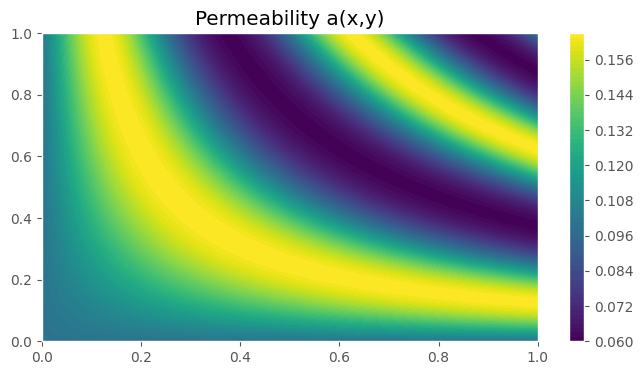

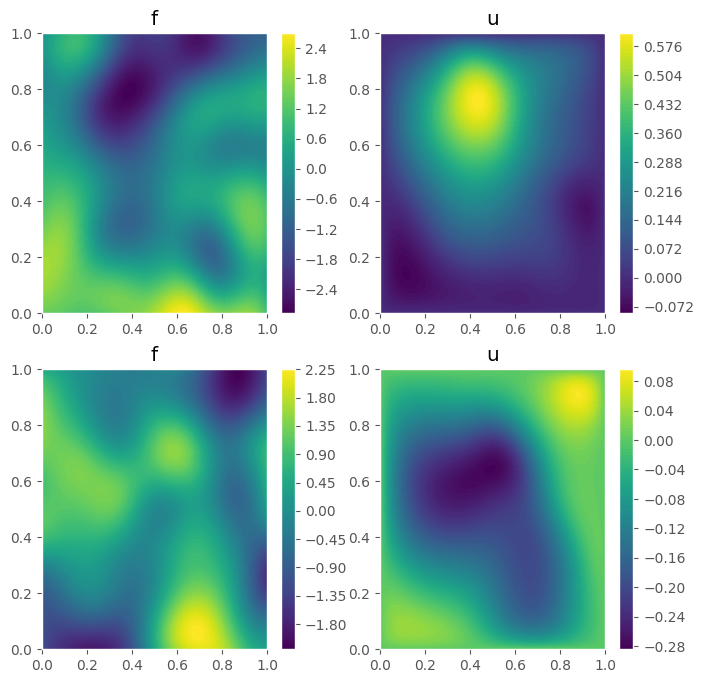

In [5]:
num_to_plot = 2
plt.figure(figsize=(8,4))
plt.title("Permeability a(x,y)")
plt.tricontourf(fine_grid[:,0],fine_grid[:,1],jax.vmap(a)(fine_grid),100)
plt.colorbar()
plt.show()
plt.figure(figsize = (8,num_to_plot * 4))
for i in range(num_to_plot):
    plt.subplot(num_to_plot,2,2*i+1)
    plt.title("f")
    plt.tricontourf(fine_grid[:,0],fine_grid[:,1],jax.vmap(rhs_functions[i])(fine_grid),100)
    plt.colorbar()
    plt.subplot(num_to_plot,2,2*(i+1))
    plt.title('u')
    plt.tricontourf(fine_grid[:,0],fine_grid[:,1],jax.vmap(u_true_functions[i])(fine_grid),100)
    plt.colorbar()
plt.show()

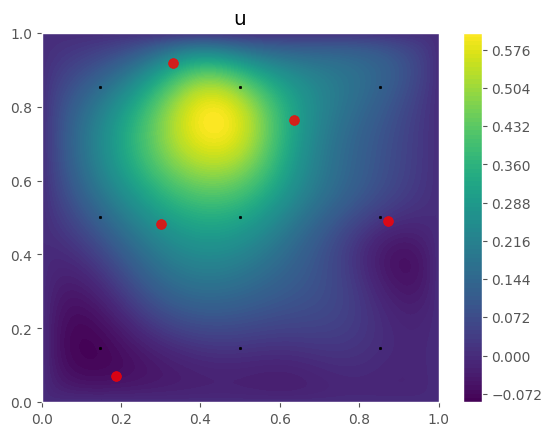

In [6]:
k_u = get_gaussianRBF(0.2)
# xy_int,xy_bdy=build_xy_grid([0,1],[0,1],20,20)

single_grid = build_alpha_chebyshev([0,1],5,1.)
xy_int,xy_bdy = make_grids(single_grid,single_grid)

xy_all = jnp.vstack([xy_int,xy_bdy])
plt.title('u')
plt.tricontourf(fine_grid[:,0],fine_grid[:,1],jax.vmap(u_true_functions[0])(fine_grid),100)
plt.colorbar()
plt.scatter(xy_int[:,0],xy_int[:,1],c = 'black',s = 3)
plt.scatter(xy_obs[0][:,0],xy_obs[0][:,1],c = 'red',s = 50,alpha = 0.8)
plt.show()

In [7]:
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])
basis_operators = tuple([eval_k,diff_xx_op,diff_yy_op])

u_model = CholInducedRKHS(
    xy_all,
    basis_operators,
    k_u
)


observation_points = tuple(jnp.vstack([xy_bdy,obs]) for obs in xy_obs)
observation_values = tuple(jax.vmap(u)(obs_loc) for u,obs_loc in zip(u_true_functions,observation_points))
collocation_points = (xy_int,)*num_functions

rhs_values = tuple(jax.vmap(rhs_func)(int_points) for rhs_func,int_points in zip(rhs_functions,collocation_points))

all_u_params_init = tuple([
    u_model.get_fitted_params(obs_loc,obs_val) 
    for obs_loc,obs_val in zip(observation_points,observation_values)
    ]
    )

In [8]:
grid_features_u_init = [(
    u_model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        ) for model_params in all_u_params_init
        ]
grid_features_u_init = jnp.vstack([jnp.hstack([xy_int,features]) for features in grid_features_u_init])

num_P_inducing = 250
input_feature_sample = jax.random.choice(pkey(320),grid_features_u_init,(num_P_inducing,))
k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init[:,2:],c=1)
k_P_x_part = get_gaussianRBF(0.25)
def k_P(x,y):
    return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])

P_model = InducedOperatorModel(input_feature_sample,k_P)
P_init = P_model.get_fitted_params(grid_features_u_init,jnp.hstack(rhs_values),lam = 1e-4)

In [10]:
params_init = jnp.hstack(list(all_u_params_init)+[P_init])
EqnModel  = SharedOperatorPDEModel(
    P_model,
    u_model,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_values,
    datafit_weight = 10.,
    num_P_operator_params=num_P_inducing
)

In [11]:
u_params = all_u_params_init
P_params = P_init

In [13]:
datafit_weight = 100.

def single_function_residuals(
    u_param,
    P_params,
    single_collocation_points,
    single_rhs,
    single_observation_points,
    single_observation_values,
):
    datafit_res = EqnModel.datafit_residual_single(
        u_param,
        single_observation_points,
        single_observation_values,
    )

    eqn_res = EqnModel.equation_residual_single(
        u_param,
        P_params,
        single_collocation_points,
        single_rhs
    )
    return jnp.hstack([datafit_res*jnp.sqrt(datafit_weight/len(datafit_res)),eqn_res/jnp.sqrt(len(eqn_res))])

In [11]:
P_params = EqnModel.get_P_params(lbfgs_sol)
u_params = EqnModel.get_u_params(lbfgs_sol)

In [12]:
def build_darcy_op(a):
    def darcy_op(k,index):
        gradk = jax.grad(k,argnums = index)
        def agradk(*args):
            return a(args[index])*gradk(*args)
        def darcy_result(*args):
            return jnp.trace(jax.jacfwd(agradk,argnums = index)(*args))
        return darcy_result
    return darcy_op
darcy_op = build_darcy_op(a)

In [19]:
grid = jnp.linspace(-0.00,1.00,50)
x,y = jnp.meshgrid(grid,grid)
fine_grid_int = jnp.vstack([x.flatten(),y.flatten()]).T
eqnFeatures = EqnModel.single_eqn_features(u_params[0],fine_grid_int)
Phat_uhat = P_model.predict(eqnFeatures,P_params)

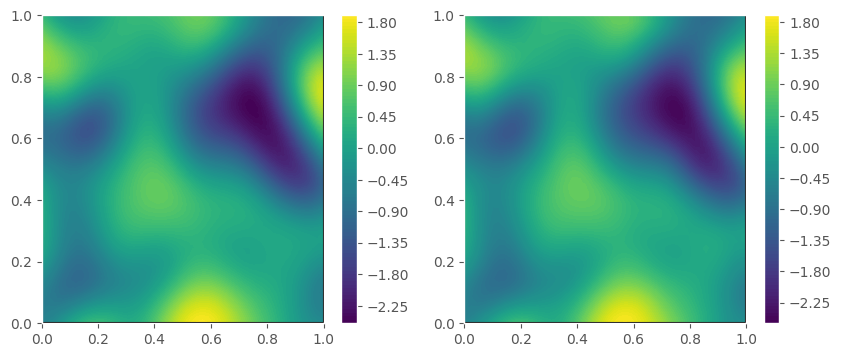

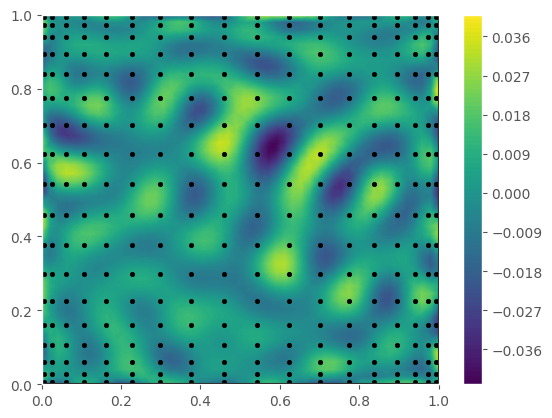

In [20]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.tricontourf(fine_grid_int[:,0],fine_grid_int[:,1],jax.vmap(rhs_functions[0])(fine_grid_int),100)
plt.plot([0,1,1,0,0],[1,1,0,0,1],c='black')

plt.colorbar()
plt.subplot(1,2,2)
plt.tricontourf(fine_grid_int[:,0],fine_grid_int[:,1],Phat_uhat,100)
plt.plot([0,1,1,0,0],[1,1,0,0,1],c='black')

plt.colorbar()
plt.show()
plt.tricontourf(fine_grid_int[:,0],fine_grid_int[:,1],jax.vmap(rhs_functions[0])(fine_grid_int) - Phat_uhat,100)
plt.plot([0,1,1,0,0],[1,1,0,0,1],c='black')

plt.colorbar()
plt.scatter(xy_int[:,0],xy_int[:,1],c = 'black',s = 10)
plt.show()

In [21]:
jnp.linalg.norm(jax.vmap(rhs_functions[0])(fine_grid_int) - Phat_uhat)/jnp.linalg.norm(jax.vmap(rhs_functions[0])(fine_grid_int))

Array(0.01389345, dtype=float64)

In [24]:

percent_errors = []
for i in range(num_functions):
    u_vals = u_model.point_evaluate(fine_grid_int,u_params[i])
    u_true_vals = jax.vmap(u_true_functions[i])(fine_grid_int)
    percent_errors.append(jnp.linalg.norm(u_vals - u_true_vals)/jnp.linalg.norm(u_true_vals))
jnp.mean(jnp.array(percent_errors))

Array(1.14977236, dtype=float64)

(array([1., 0., 2., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 2., 1.]),
 array([0.44910615, 0.52157843, 0.59405071, 0.66652299, 0.73899527,
        0.81146755, 0.88393983, 0.95641211, 1.02888439, 1.10135667,
        1.17382896, 1.24630124, 1.31877352, 1.3912458 , 1.46371808,
        1.53619036, 1.60866264, 1.68113492, 1.7536072 , 1.82607948,
        1.89855176]),
 <BarContainer object of 20 artists>)

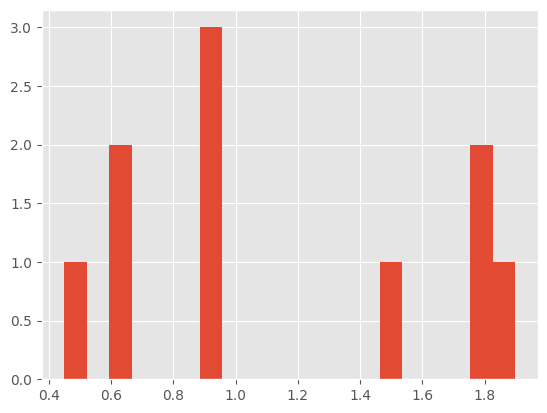

In [28]:
plt.hist(jnp.array(percent_errors),20)

In [25]:
print(
    jnp.linalg.norm(EqnModel.stacked_datafit_residual(u_params))/
    jnp.linalg.norm(jnp.hstack(observation_values))
)
print(
    jnp.linalg.norm(EqnModel.stacked_equation_residual(u_params,P_params))/(
    jnp.linalg.norm(EqnModel.stacked_collocation_rhs)
)
)

0.03032444327331814
0.015362623794768701


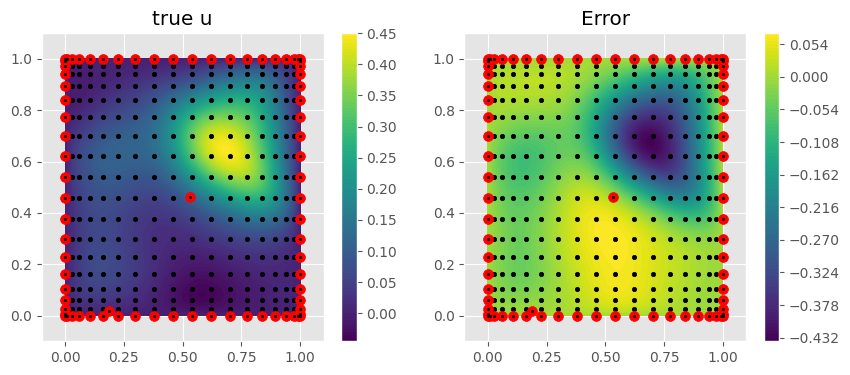

In [26]:
u0 = u_model.point_evaluate(fine_grid_int,u_params[0])
u0_true = jax.vmap(u_true_functions[0])(fine_grid_int)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("true u")
plt.tricontourf(fine_grid_int[:,0],fine_grid_int[:,1],u0_true,100)
plt.colorbar()
plt.scatter(xy_int[:,0],xy_int[:,1],c='black',s=10)
plt.scatter(xy_obs[0][:,0],xy_obs[0][:,1],c='red',s=50)
plt.scatter(xy_obs[0][:,0],xy_obs[0][:,1],c='black',s=3)
plt.scatter(xy_bdy[:,0],xy_bdy[:,1],c='red',s=50)
plt.scatter(xy_bdy[:,0],xy_bdy[:,1],c='black',s=3)
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.subplot(1,2,2)

plt.title("Error")
plt.tricontourf(fine_grid_int[:,0],fine_grid_int[:,1],u0 - u0_true,100)
plt.colorbar()
plt.scatter(xy_int[:,0],xy_int[:,1],c='black',s=10)
plt.scatter(xy_obs[0][:,0],xy_obs[0][:,1],c='red',s=50)
plt.scatter(xy_obs[0][:,0],xy_obs[0][:,1],c='black',s=3)
plt.scatter(xy_bdy[:,0],xy_bdy[:,1],c='red',s=50)
plt.scatter(xy_bdy[:,0],xy_bdy[:,1],c='black',s=3)
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.show()

0.8810697721626332


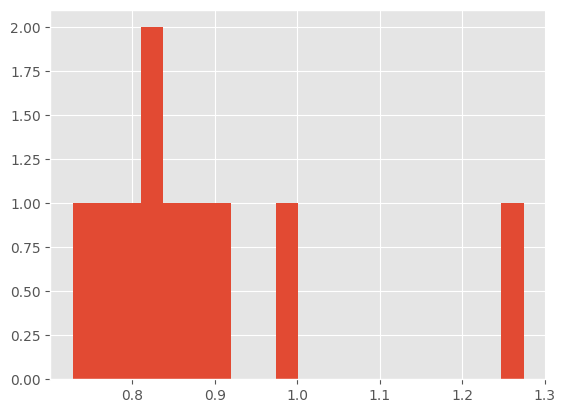

In [27]:
percent_errors_init = []
for i in range(num_functions):
    u_vals = u_model.point_evaluate(fine_grid_int,all_u_params_init[i])
    u_true_vals = jax.vmap(u_true_functions[i])(fine_grid_int)
    percent_errors_init.append(jnp.linalg.norm(u_vals - u_true_vals)/jnp.linalg.norm(u_true_vals))
print(jnp.mean(jnp.array(percent_errors_init)))
plt.hist(percent_errors_init,20)
plt.show()

## TODO
First define the single stacked equation + datafit residual

Then jacobian through it and then vmap the stacked u update

then update the P params. 

The current order is wrong, with vmaps inside, should put outside. Then can calculate both the residual and jacobians. 

Essentially write a "update_step_single" function


In [115]:
datafit_jacobians = jax.vmap(jax.jacrev(EqnModel.datafit_residual_single,argnums = 0))(
    jnp.vstack(u_params),
    jnp.stack(EqnModel.observation_points),
    jnp.vstack(EqnModel.observation_values)
)

equation_jacobians = jax.vmap(
    jax.jacrev(EqnModel.equation_residual_single,argnums = 0),
    in_axes = (0,None,0,0)
    )(
    jnp.vstack(u_params),
    P_params,
    jnp.stack(EqnModel.collocation_points),
    jnp.vstack(EqnModel.rhs_forcing_values)
)
print(equation_jacobians.shape)
print(datafit_jacobians.shape)


full_u_jacobians = jax.vmap(lambda x,y:jnp.vstack([x,y]))(datafit_jacobians,equation_jacobians)


datafit_weight = 100.

def single_function_residuals(
    u_param,
    single_collocation_points,
    single_rhs,
    single_observation_points,
    single_observation_values,
    P_params
):
    datafit_res = EqnModel.datafit_residual_single(
        u_param,
        single_observation_points,
        single_observation_values,
    )

    eqn_res = EqnModel.equation_residual_single(
        u_param,
        P_params,
        single_collocation_points,
        single_rhs
    )
    return jnp.hstack([datafit_res*jnp.sqrt(datafit_weight/len(datafit_res)),eqn_res/jnp.sqrt(len(eqn_res))])

(10, 324, 1200)
(10, 78, 1200)


In [116]:
datafit_weight = 100.

def single_function_residuals(
    u_param,
    single_collocation_points,
    single_rhs,
    single_observation_points,
    single_observation_values,
    P_params
):
    datafit_res = EqnModel.datafit_residual_single(
        u_param,
        single_observation_points,
        single_observation_values,
    )

    eqn_res = EqnModel.equation_residual_single(
        u_param,
        P_params,
        single_collocation_points,
        single_rhs
    )
    return jnp.hstack([datafit_res*jnp.sqrt(datafit_weight/len(datafit_res)),eqn_res/jnp.sqrt(len(eqn_res))])

In [117]:
colloc_array = jnp.stack(EqnModel.collocation_points)
rhs_array = jnp.stack(EqnModel.rhs_forcing_values)
obs_point_array = jnp.stack(EqnModel.observation_points)
obs_val_array = jnp.stack(EqnModel.observation_values)



def rf(u):
    return single_function_residuals(
        u,
        EqnModel.collocation_points[0],
        EqnModel.rhs_forcing_values[0],
        EqnModel.observation_points[0],
        EqnModel.observation_values[0],
        P_params
    )

res = single_function_residuals(
    u_params[0],
    EqnModel.collocation_points[0],
    EqnModel.rhs_forcing_values[0],
    EqnModel.observation_points[0],
    EqnModel.observation_values[0],
    P_params
)

In [118]:
from Optimizers import l2reg_lstsq
u = 0*u_params[0]
J = jax.jacrev(rf)(u)
F = rf(u)

In [119]:
u_new = -1*l2reg_lstsq(J,F,1e-20)
u_new

Array([ 3.31570415e+01, -5.48625210e+02,  3.65804730e+03, ...,
        1.99550178e+05,  1.96519102e+05,  1.07321875e+06], dtype=float64)

In [120]:
jnp.linalg.norm(rf(u_new))

Array(0.00187077, dtype=float64)

In [121]:
jnp.linalg.norm(rf(u_params[0]))

Array(0.01136973, dtype=float64)

In [122]:
u_vals = u_model.point_evaluate(fine_grid_int,u_new)
u_true_vals = jax.vmap(u_true_functions[0])(fine_grid_int)
(jnp.linalg.norm(u_vals - u_true_vals)/jnp.linalg.norm(u_true_vals))

Array(0.90269571, dtype=float64)